# Image Classification Inference using TF Lite Runtime
In this example notebook, we describe how to use a pre-trained Classification model for inference using the ***Tensorflow Lite Runtime*** interface.
   - The user can choose the model (see section titled *Choosing a Pre-Compiled Model*)
   - The models used in this example were trained on the ***ImageNet*** dataset because it is a widely used dataset developed for training and benchmarking image classification AI models. 
   - We perform inference on a few sample images.
   - We also describe the input preprocessing and output postprocessing steps, demonstrate how to collect various benchmarking statistics and how to visualize the data.
   
## Choosing a Pre-Compiled Model
We provide a set of precompiled artifacts to use with this notebook that will appear as a drop-down list once the first code cell is executed.

<img src=docs/images/drop_down.PNG width="400">

## Image classification
Image classification is a popular computer vision algorithm used in applications such as, object recongnition, traffic sign recongnition and traffic light recongnition. Image classification models are also used as feature extractors for other tasks such as object detection and semantic segmentation.
   - The image below shows classification results on few sample images.
   - Note: in this example, we used models trained with ***ImageNet*** because it is a widely used dataset developed for training and benchmarking image classifcation AI models

<img src=docs/images/CLS.PNG width="500">


## Tensorflow Lite Runtime based Work flow
The diagram below describes the steps for Tensorflow Lite Runtime based workflow. 

Note:
- The user needs to compile models(sub-graph creation and quantization) on a PC to generate model artifacts.
    - For this notebook we use pre-compiled models artifacts
- The generated artifacts can then be used to run inference on the target.
- Users can run this notebook as-is, only action required is to select a model. 

<img src=docs/images/tflrt_work_flow_2.png width="400">

In [1]:
import os
import cv2
import numpy as np
import ipywidgets as widgets
from scripts.utils import get_eval_configs
last_artifacts_id = selected_model_id.value if "selected_model_id" in locals() else None
prebuilt_configs, selected_model_id = get_eval_configs('classification','tflitert', num_quant_bits = 8, last_artifacts_id = last_artifacts_id)
display(selected_model_id)

Dropdown(description='Select Model:', options=(('TFL-CL-0000-mobileNetV1-mlperf', 'cl-0000'), ('TFL-CL-0080-mo…

In [2]:
print(f'Selected Model: {selected_model_id.label}')
config = prebuilt_configs[selected_model_id.value]
config['session'].set_param('model_id', selected_model_id.value)
config['session'].start()

Selected Model: TFL-CL-0000-mobileNetV1-mlperf
INFO:20220318-093932: model_path - /data/ssd/files/a0393608/work/code/ti/processor-sdk-vision/edgeai-tidl-tools/examples/edgeai-modelzoo/models/vision/classification/imagenet1k/mlperf/mobilenet_v1_1.0_224.tflite
INFO:20220318-093932: model_file - /data/ssd/files/a0393608/work/code/ti/processor-sdk-vision/edgeai-tidl-tools/examples/jupyter_notebooks/prebuilt-models/8bits/cl-0000_tflitert_imagenet1k_mlperf_mobilenet_v1_1.0_224_tflite/model/mobilenet_v1_1.0_224.tflite


## Define utility function to preprocess input images

Below, we define a utility function to preprocess images for the model. This function takes a path as input, loads the image and preprocesses the images as required by the model. The steps below are shown as a reference (no user action required):

 1. Load image
 2. Convert BGR image to RGB
 3. Scale image
 4. Apply per-channel pixel scaling and mean subtraction
 5. Convert RGB Image to BGR. 
 6. Convert the image to NCHW format


- The input arguments of this utility function is selected automatically by this notebook based on the model selected in the drop-down

In [3]:
def preprocess(image_path, size, mean, scale, layout, reverse_channels):
    # Step 1
    img = cv2.imread(image_path)
    
    # Step 2
    img = img[:,:,::-1]
    
    # Step 3
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
     
    # Step 4
    img = img.astype('float32')
    if mean is not None and scale is not None:        
        for mean, scale, ch in zip(mean, scale, range(img.shape[2])):
            img[:,:,ch] = ((img.astype('float32')[:,:,ch] - mean) * scale)
    # Step 5
    if reverse_channels:
        img = img[:,:,::-1]
        
    # Step 6
    if layout == 'NCHW':
        img = np.expand_dims(np.transpose(img, (2,0,1)),axis=0)
    else:
        img = np.expand_dims(img,axis=0)
    
    return img

## Create the model using the stored artifacts

In [4]:
import tflite_runtime.interpreter as tflite

tflite_model_path = config['session'].get_param('model_file')
artifacts_dir = config['session'].get_param('artifacts_folder')

tidl_delegate = [tflite.load_delegate('libtidl_tfl_delegate.so', {'artifacts_folder': artifacts_dir})]

interpreter = tflite.Interpreter(model_path=tflite_model_path, experimental_delegates=tidl_delegate)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Run the model for inference

### Preprocessing and Inference

   - You can use a portion of images provided in `/sample-images` directory to evaluate the classification inferences. In the cell below, we use a loop to preprocess the selected images, and provide them as the input to the network.

### Postprocessing and Visualization

 - Once the inference results are available, we postpocess the results and visualize the inferred classes for each of the input images.
 - Classification models return the results as a list of `numpy.ndarray`, containing one element which is an array with `shape` = `(1,1000)` and `dtype` = `'float32'`, where each element represents the activation for a particular ***ImageNet*** class. The results from the these inferences above are postprocessed using `argsort()` to get the `TOP-5` class IDs and the corresponding names using `imagenet_class_to_name()`.
 - Then, in this notebook, we use *matplotlib* to plot the original images and the corresponding results.

In [5]:
from scripts.utils import get_preproc_props

# use results from the past inferences
images = [
    ('sample-images/elephant.bmp', 221),
    ('sample-images/laptop.bmp', 222),
    ('sample-images/bus.bmp', 223),
    ('sample-images/zebra.bmp', 224),
]
size, mean, scale, layout, reverse_channels = get_preproc_props(config)    
print(f'Image size: {size}')

Image size: 224


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


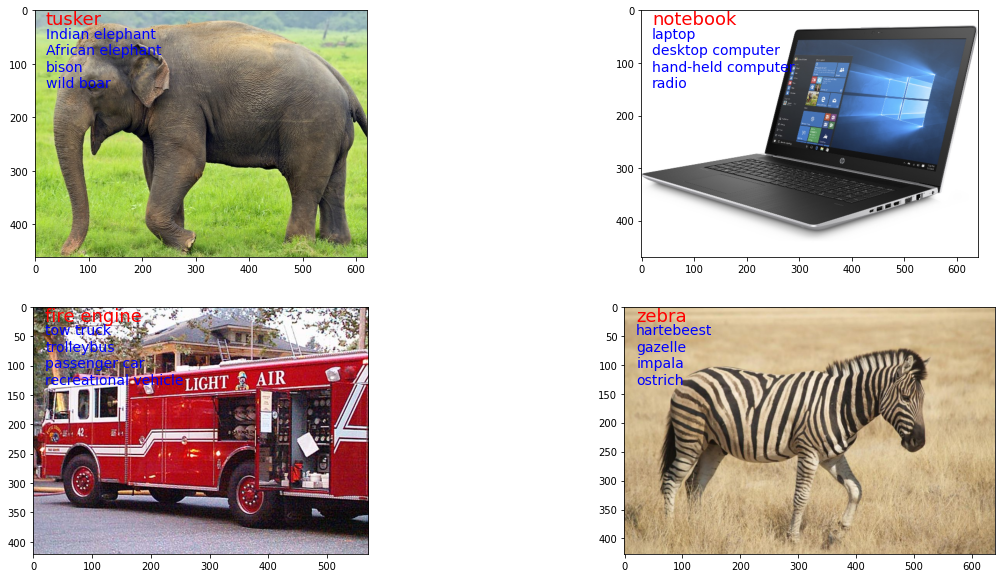

In [6]:
import tqdm
import matplotlib.pyplot as plt
from scripts.utils import imagenet_class_to_name

plt.figure(figsize=(20,10))

for num in tqdm.trange(len(images)):
    image_file, grid = images[num]
    img = cv2.imread(image_file)[:,:,::-1]
    ax = plt.subplot(grid)

    img_in = preprocess(image_file , size, mean, scale, layout, reverse_channels) 
    if not input_details[0]['dtype'] == np.float32:
        img_in = np.uint8(img_in)

    interpreter.set_tensor(input_details[0]['index'], img_in)
    interpreter.invoke()
    res = interpreter.get_tensor(output_details[0]['index'])

    # get the TOP-5 class IDs by argsort()
    # and use utility function to get names
    output = res.squeeze()[1:]
    classes = output.argsort()[-5:][::-1]
    outputoffset = 0 if(output.shape[0] == 1000) else 1 
    names = [imagenet_class_to_name(x+outputoffset)[0] for x in classes]
  
    # plot the TOP-5 class names
    ax.text(20, 0 * img.shape[0] / 15, names[0], {'color': 'red',  'fontsize': 18, 'ha': 'left', 'va': 'top'})
    ax.text(20, 1 * img.shape[0] / 15, names[1], {'color': 'blue', 'fontsize': 14, 'ha': 'left', 'va': 'top'})
    ax.text(20, 2 * img.shape[0] / 15, names[2], {'color': 'blue', 'fontsize': 14, 'ha': 'left', 'va': 'top'})
    ax.text(20, 3 * img.shape[0] / 15, names[3], {'color': 'blue', 'fontsize': 14, 'ha': 'left', 'va': 'top'})
    ax.text(20, 4 * img.shape[0] / 15, names[4], {'color': 'blue', 'fontsize': 14, 'ha': 'left', 'va': 'top'})
    
    # Show the original image
    ax.imshow(img)
    
plt.show()

## Plot Inference benchmarking statistics

 - During the model execution several benchmarking statistics such as timestamps at different checkpoints, DDR bandwidth are collected and stored. `get_TI_benchmark_data()` can be used to collect these statistics. This function returns a dictionary of `annotations` and the corresponding markers.
 - We provide the utility function plot_TI_benchmark_data to visualize these benchmark KPIs

<div class="alert alert-block alert-info">
<b>Note:</b> The values represented by <i>Inferences Per Second</i> and <i>Inference Time Per Image</i> uses the total time taken by the inference except the time taken for copying inputs and outputs. In a performance oriented system, these operations can be bypassed by writing the data directly into shared memory and performing on-the-fly input / output normalization.
</div>


In [ ]:
from scripts.utils import plot_TI_performance_data, plot_TI_DDRBW_data, get_benchmark_output
stats = interpreter.get_TI_benchmark_data()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plot_TI_performance_data(stats, axis=ax)
plt.show()

tt, st, rb, wb = get_benchmark_output(stats)

print(f'SoC: J721E/DRA829/TDA4VM')
print(f' OPP:')
print(f'  Cortex-A72 @2GHZ')
print(f'  DSP C7x-MMA @1GHZ')
print(f'  DDR @4266 MT/s\n')
print(f'{selected_model_id.label} :')
print(f' Inferences Per Second    : {1000.0/tt :7.2f} fps')
print(f' Inference Time Per Image : {tt :7.2f} ms')
print(f' DDR usage Per Image      : {rb+ wb : 7.2f} MB')